In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/SupervisedML/BK/

Mounted at /gdrive
/gdrive/MyDrive/SupervisedML/BK


# Imports and Load Data

In [2]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

np.random.seed = 47

# Data from: https://www.kaggle.com/datasets/outofskills/driving-behavior/code?select=test_motion_data.csv
data = pd.read_csv('Bankruptcy_data_Final.csv', header=0)
data.head()

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1979,0.98,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN,0
1,1980,0.98,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126,0.014,0.040,0
2,1981,0.87,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368,0.328,0.567,0
3,1982,1.13,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.021,-0.119,-0.096,0
4,1983,1.26,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233,0.147,0.053,0


# Preprocess Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81204 entries, 1 to 92871
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data Year - Fiscal  81204 non-null  int64  
 1   Tobin's Q           81204 non-null  float64
 2   EPS                 81204 non-null  float64
 3   Liquidity           81204 non-null  float64
 4   Profitability       81204 non-null  float64
 5   Productivity        81204 non-null  float64
 6   Leverage Ratio      81204 non-null  float64
 7   Asset Turnover      81204 non-null  float64
 8   Operational Margin  81204 non-null  float64
 9   Return on Equity    81204 non-null  float64
 10  Market Book Ratio   81204 non-null  float64
 11  Assets Growth       81204 non-null  float64
 12  Sales Growth        81204 non-null  float64
 13  Employee Growth     81204 non-null  float64
 14  BK                  81204 non-null  int64  
dtypes: float64(13), int64(2)
memory usage: 9.9 MB


In [3]:
# Check for null values

data_null = data.isnull().sum()
data_null

Data Year - Fiscal       0
Tobin's Q              252
EPS                      5
Liquidity              247
Profitability          247
Productivity           247
Leverage Ratio          26
Asset Turnover         247
Operational Margin    5557
Return on Equity         8
Market Book Ratio       57
Assets Growth         6701
Sales Growth          6701
Employee Growth       7010
BK                       0
dtype: int64

In [4]:
# Drop NaN values

data = data.dropna()
data.shape

(81204, 15)

In [6]:
np.unique(data['BK'])

array([0, 1])

# Exploratory Data Analysis

In [7]:
describe = data.describe().T
describe

,count,mean,std,min,25%,50%,75%,max
Data Year - Fiscal,81204.0,2004.175952,9.682015,1980.000,1998.000,2006.0000,2012.000,2017.00
Tobin's Q,81204.0,5.343516,127.527964,0.060,1.110,1.4900,2.360,25969.27
EPS,81204.0,-16.056183,2343.250560,-384000.000,-0.120,0.4805,1.680,55339.00
Liquidity,81204.0,-1.006692,98.550174,-25968.520,0.030,0.1900,0.390,1.00
Profitability,81204.0,-9.253443,269.793394,-26097.600,-0.390,0.1100,0.340,140.58
Productivity,81204.0,-0.266862,6.993373,-1241.000,-0.020,0.0600,0.120,35.92
Leverage Ratio,81204.0,1.505365,270.550286,-7811.000,0.010,0.3300,0.860,75970.38
Asset Turnover,81204.0,1.124603,2.216563,-31.590,0.470,0.8900,1.430,276.38
Operational Margin,81204.0,-7.540954,215.120128,-30175.700,-0.020,0.0600,0.140,394.47
Return on Equity,81204.0,-2.708753,348.369194,-88875.140,-0.060,0.0400,0.070,11228.85


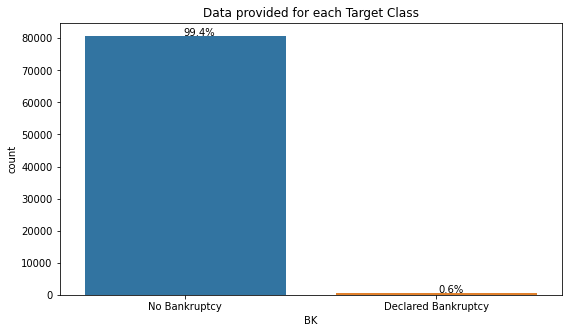

In [11]:
plt.figure(figsize=(9,5))

total = float(len(data))

ax = sns.countplot(x="BK", data=data)
plt.title('Data provided for each Target Class', fontsize=12)
ax.set_xticklabels(['No Bankruptcy','Declared Bankruptcy'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/1.75
    y = p.get_height() +2
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

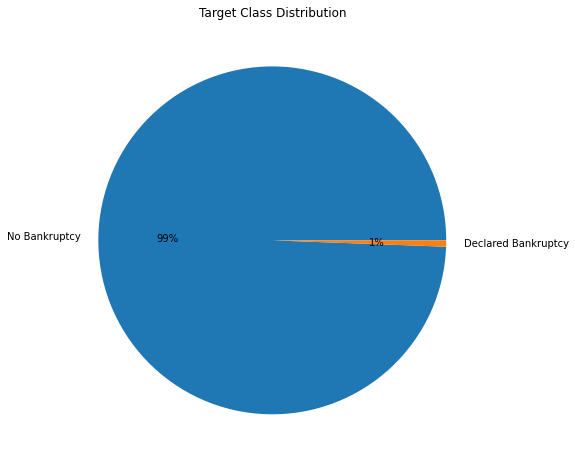

In [14]:
plt.figure(figsize=(10,8))

plt.pie(data.BK.value_counts().values, 
        labels=['No Bankruptcy','Declared Bankruptcy'], 
        autopct='%.0f%%')

plt.title("Target Class Distribution")
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

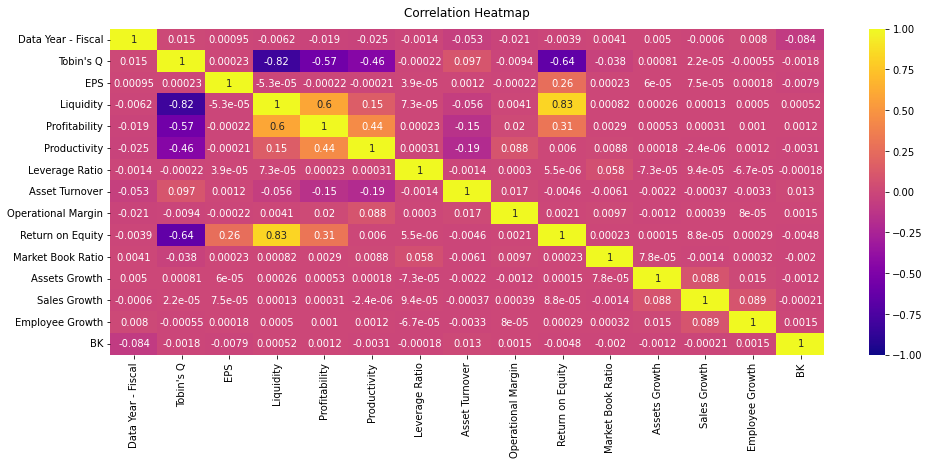

In [8]:
import seaborn as sns

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(data.corr(), cmap="plasma", vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
sns.pairplot(data, hue='BK', palette="Spectral")

# SMOTE for uneven distribution

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = data.drop(columns='BK')
y = data['BK']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print('-------------\nTraining Data \n-------------')
print(f'Features: {X_train.shape}')
print(f'Target:   {y_train.shape}\n')

print('-------------\nTesting Data \n-------------')
print(f'Features: {X_test.shape}')
print(f'Target:   {y_test.shape}')

-------------
Training Data 
-------------
Features: (64963, 14)
Target:   (64963,)

-------------
Testing Data 
-------------
Features: (16241, 14)
Target:   (16241,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print('-------------\nTraining Data \n-------------')
print(f'Features: {X_train.shape}')
print(f'Target:   {y_train.shape}\n')

print('-------------\nTesting Data \n-------------')
print(f'Features: {X_test.shape}')
print(f'Target:   {y_test.shape}')

-------------
Training Data 
-------------
Features: (64963, 14)
Target:   (64963,)

-------------
Testing Data 
-------------
Features: (16241, 14)
Target:   (16241,)


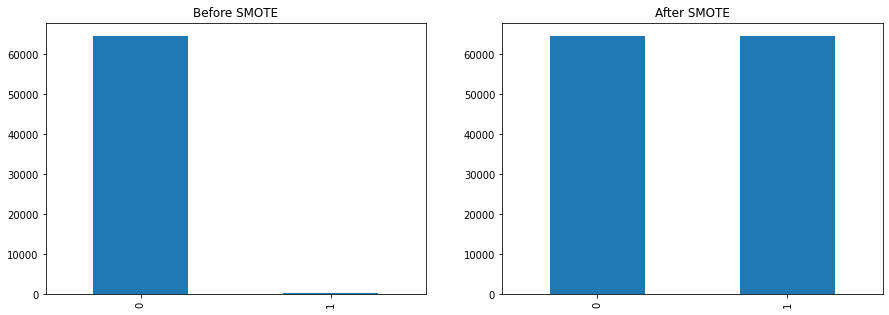

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.bar(ax=ax2)

plt.show()

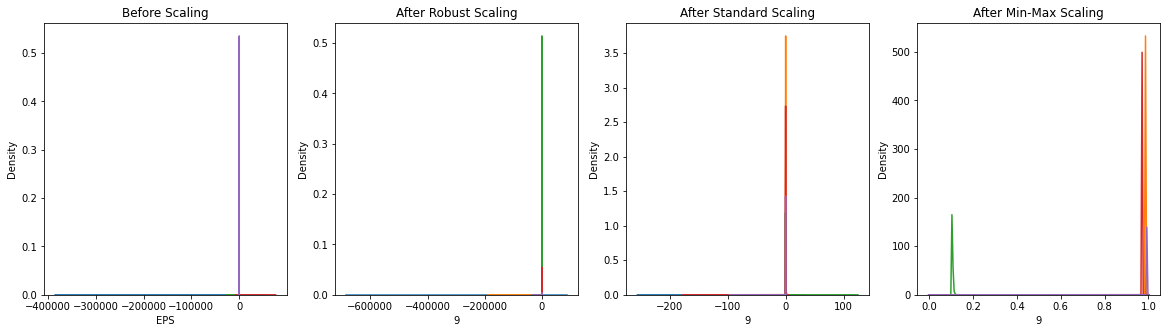

In [19]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

df = data.copy()



# to compare the effect of each scaler on our dataset
scaler = RobustScaler()
robust_df = scaler.fit_transform(df)
robust_df = pd.DataFrame(robust_df)
  
scaler = StandardScaler()
standard_df = scaler.fit_transform(df)
standard_df = pd.DataFrame(standard_df)
  
scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(df)
minmax_df = pd.DataFrame(minmax_df)

# using KDE plot
#Note: some columns are opted out in order to speed up the process
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['EPS'], ax = ax1)
sns.kdeplot(df['Liquidity'], ax = ax1)
sns.kdeplot(df['Profitability'], ax = ax1)
sns.kdeplot(df['Leverage Ratio'], ax = ax1)
sns.kdeplot(df['Asset Turnover'], ax = ax1)


ax2.set_title('After Robust Scaling')  
sns.kdeplot(robust_df[9], ax = ax2)
sns.kdeplot(robust_df[8], ax = ax2)
sns.kdeplot(robust_df[7], ax = ax2)
sns.kdeplot(robust_df[5], ax = ax2)
sns.kdeplot(robust_df[4], ax = ax2)


ax3.set_title('After Standard Scaling')  
sns.kdeplot(standard_df[9], ax = ax3)
sns.kdeplot(standard_df[8], ax = ax3)
sns.kdeplot(standard_df[7], ax = ax3)
sns.kdeplot(standard_df[5], ax = ax3)
sns.kdeplot(standard_df[4], ax = ax3)


ax4.set_title('After Min-Max Scaling')  
sns.kdeplot(minmax_df[9], ax = ax4)
sns.kdeplot(minmax_df[8], ax = ax4)
sns.kdeplot(minmax_df[7], ax = ax4)
sns.kdeplot(minmax_df[5], ax = ax4)
sns.kdeplot(minmax_df[4], ax = ax4)

plt.show()

# Other start


In [ ]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = pd.read_csv('Bankruptcy_data_Final.csv', header=0)
df = data.dropna()
df

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
1,1980,0.980,1.410,0.360,0.190,0.120,1.310,1.590,0.070,0.130,2.410,0.126,0.014,0.040,0
2,1981,0.870,0.310,0.320,0.130,0.080,1.030,1.550,0.050,0.040,2.560,0.368,0.328,0.567,0
3,1982,1.130,0.710,0.280,0.140,0.080,0.800,1.390,0.060,0.050,5.280,-0.021,-0.119,-0.096,0
4,1983,1.260,0.750,0.410,0.130,0.080,0.200,1.300,0.060,0.040,8.680,0.233,0.147,0.053,0
5,1984,1.170,1.500,0.370,0.160,0.110,0.340,1.410,0.080,0.080,7.820,0.132,0.232,0.077,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92867,2009,1.521,-1.488,-0.015,-0.759,-0.057,-1042.105,0.174,-0.327,-6.614,-1.847,-0.073,-0.557,-0.077,0
92868,2010,1.988,-1.808,0.094,-1.205,-0.121,-4.530,0.216,-0.561,-4.519,-2.475,-0.202,-0.011,-0.208,0
92869,2011,0.924,-0.016,0.039,0.000,-0.082,0.745,0.254,-0.324,-0.569,3274.506,-0.168,-0.020,-0.105,0
92870,2012,0.788,-0.133,0.054,-0.029,0.001,0.575,0.196,0.005,-0.086,36.475,0.077,-0.171,-0.059,0


In [ ]:
z = np.array(df.drop(['BK'], axis=1))
#z[0]

a = np.asarray(df.iloc[:, 14]).astype(np.float32)
a[81203]

1.0

In [ ]:
FEATURES = 14
LABELS = 2

X = np.array(df.drop(['BK'], axis=1))
y = np.asarray(df.iloc[:, 14]).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)


In [ ]:
y_test.shape

(16241,)

In [ ]:
# As ML/DL algorithms are working with numbers
# the labels should be mapped to numbers
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

# As the dataset contains variables that are different in scale,
# a good solution will be to standardize it
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_test.shape

(16241,)

In [ ]:
# Because I'm using CategoricalCrossentropy loss function
# I have to convert my labels to one-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)

y_test.shape

(16241, 2)

In [ ]:
# As ML/DL algorithms are working with numbers
# the labels should be mapped to numbers
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)



# Because I'm using CategoricalCrossentropy loss function
# I have to convert my labels to one-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)



# As the dataset contains variables that are different in scale,
# a good solution will be to standardize it
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print('--- Train ---')
print(X_train.shape)
print(X_test.shape)

print('\n--- Test ---')
print(y_train.shape)
print(y_test.shape)

--- Train ---
(64963, 14)
(16241, 14)

--- Test ---
(64963,)
(16241,)


In [ ]:
X_train.shape[1]

14

In [ ]:
FEATURES = 14

In [ ]:
!pip install keras_tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, LSTM, RepeatVector
import keras_tuner as kt

# Set a global random seed for a better random result
tf.random.set_seed(42)

# Build the model by assigning
# the number of layers and number of neurons for each layer
# the learning rate
# the number of epochs
# ------------------------------------------------------------------------
# To get these optimal parameters I will use the Keras Tuner library
# so it will get the optimal parameters for the NN
# and pass it to the model_builder function
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(Dense(hp.Int('input_unit', min_value=32, max_value=512, step=32), input_shape=[X_train.shape[1]]))
        
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32)))

    model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='softmax'))
    

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [ ]:
# To be able to get the optimal parameters for our network
# we have to create a Tuner with the following setup
# 'objective' -> will use to create test models
# 'max_epochs' -> the maximum number of epochs to train one model
# 'factor' -> the reduction factor for the number of epochs and number of models for each bracket
# 'directory' -> will save the training history there
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='BK',
                     project_name='bankruptcpy_pred')

In [ ]:
# Define an event that will stop the training
# depending of the value of "val_loss"
# ------------------------------------------------------------------
# Will stop training if the "val_loss" hasn't improved in 5 epochs.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# The algorithm trains a large number of models for a few epochs and 
# carries forward only the top-performing half of models to the next round.
tuner.search(
        x=X_train,
        y=y_train,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[stop_early], 
        shuffle=True
)

Trial 12 Complete [00h 00m 23s]
val_accuracy: 0.005726248491555452

Best val_accuracy So Far: 0.005726248491555452
Total elapsed time: 00h 03m 57s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
320               |256               |input_unit
2                 |5                 |n_layers
96                |416               |dense_0_units
0.2               |0                 |dropout_rate
0.1               |0.01              |learning_rate
256               |96                |dense_1_units
160               |416               |dense_2_units
256               |32                |dense_3_units
288               |32                |dense_4_units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1983/2031 [============================>.] - ETA: 0s - loss: 74673.9375 - accuracy: 0.0058 

KeyboardInterrupt: ignored

In [ ]:
# Get best hyperparameters that were found during the search
best_model = tuner.get_best_models()[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

best_params.values

In [ ]:
best_model.summary()

In [ ]:
# Get the metrics for our trained model
eval_result = best_model.evaluate(X_test, y_test)

#Other stop

In [ ]:
# Implement your code here
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
from tensorflow.keras.optimizers import SGD

# Stochastic Logistic Regression
model = Sequential()

model.add(Dense(units=4, input_shape=[X_train.shape[1]], activation='sigmoid', kernel_regularizer=l2(0.001)))

model.add(Dense(units=2, activation='softmax', kernel_regularizer=l2(0.001)))

# Compile model
sgd = SGD(learning_rate=0.001)
model.compile(optimizer=sgd,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 4)                 60        
                                                                 
 dense_57 (Dense)            (None, 2)                 10        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


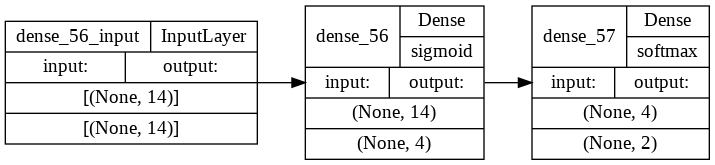

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, 
           show_layer_names=True, rankdir='LR', show_layer_activations=True)

In [ ]:
# Fit the model
history = model.fit(
    X_train, 
    y_train, 
    batch_size = 256,
    epochs = 10, 
    verbose=1, 
    validation_data=(X_test, y_test),
    shuffle=True
)

Epoch 1/10
254/254 [==============================] - 1s 5ms/step - loss: 0.1011 - accuracy: 0.9942 - val_loss: 0.0970 - val_accuracy: 0.9943
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9942 - val_loss: 0.0908 - val_accuracy: 0.9943
Epoch 3/10
254/254 [==============================] - 1s 4ms/step - loss: 0.0885 - accuracy: 0.9942 - val_loss: 0.0857 - val_accuracy: 0.9943
Epoch 4/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0838 - accuracy: 0.9942 - val_loss: 0.0813 - val_accuracy: 0.9943
Epoch 5/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0798 - accuracy: 0.9942 - val_loss: 0.0776 - val_accuracy: 0.9943
Epoch 6/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0764 - accuracy: 0.9942 - val_loss: 0.0745 - val_accuracy: 0.9943
Epoch 7/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0735 - accuracy: 0.9942 - val_loss: 0.0718 - val_accuracy: 0.9943
Epoch 

Loss after final iteration:  0.18326927721500397
Training loss after final iteration:  0.1920536905527115


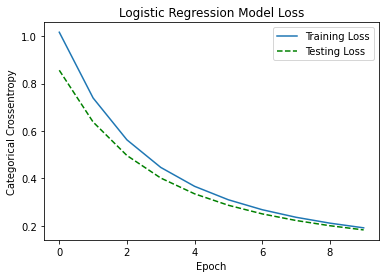

<BarContainer object of 14 artists>

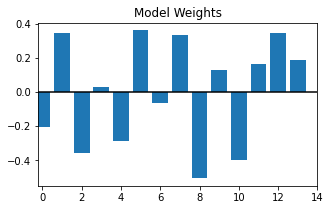

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print("Loss after final iteration: ", history.history['val_loss'][-1])
print("Training loss after final iteration: ", history.history['loss'][-1])

fig = plt.figure(figsize=(6,4))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'g--')
plt.title('Logistic Regression Model Loss')

plt.ylabel('Categorical Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()


fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.plot([-0.2,14],[0,0],color='k')
plt.xlim([-0.2,14])
plt.title('Model Weights')

Temp=model.get_weights()[0].T
plt.bar(range(len(Temp[0])),Temp[0])

In [ ]:
y_test[5586].shape

()

In [ ]:
example_1 = X_test[72]

#Using predict() and predict_classes both functions, expect the 1D version of the image
predicted = model.predict(np.array([example_1]))
predicted_class = np.argmax(predicted, axis=1)

print("posterior probabilities for of each class: {}".format(predicted))
print(f'predicted class (highest posterior): {predicted_class}')

posterior probabilities for of each class: [[0.95880204 0.04119796]]
predicted class (highest posterior): [0]


In [ ]:
import numpy as np
def ohe_to_classes(y):
    '''
        converts one hot encoding to classes
        y: a list of one-hot-encoded classes of data points
    '''
    return [np.argmax(v) for v in y]

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

predicted_all1 = model.predict(np.array(X_test))
predicted_all = np.argmax(predicted_all1, axis=1)
print("predicted classes: {}".format(predicted_all))

# Have to convert one-hot-encoding to actual classes: 0 - 9
y_true_classes = ohe_to_classes(y_test)

print('accuracy', accuracy_score(predicted_all, y_test))


predicted classes: [0 0 0 ... 0 0 0]
accuracy 0.9942737516162797


In [ ]:
import seaborn as sns

confusion_mat = confusion_matrix(predicted_all, y_true_classes)
confusion_mat


array([[16241]])

In [ ]:
print(classification_report(predicted_all, y_true_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16241

    accuracy                           1.00     16241
   macro avg       1.00      1.00      1.00     16241
weighted avg       1.00      1.00      1.00     16241

